# Predict activity
## A notebook for predicting the activity of a set of compounds
The top 3 models (KNN, Random Forest and XGBoost) are used here for classifying a new set of compounds, and show to be relatively good classifiers. The confusion matrices show that KNeighborsClassifier had the highest true postive rate and the highest AUC, which are both important factors in drug discovery. However, none of the three classifiers correlated with the experimental activity values (fluorescence) according to the Spearman correlation values, indicating they had low early recognition (the classifiers couldn't rank the compounds according to their likelihood of being more active than others). 
## Instructions
1. Define the name of the file that contains the compounds. Each molecule must...
    1. ...be identified by "CID";
    2. ...have an activity label (either active or inactive);
    3. ...have values for the molecular descriptors defined in [Classifiers and molecular descriptors](#classifiers).
    
## How it works
The models have already been trained and serialized (saved) to a pickle file. They are loaded and receive as input the activity data and values of molecular descriptors for a set of compounds. Finally, the models predict the activity of these compounds based on the data they have been previously trained on. 

## Table of contents
1. [Read data](#read)
2. [Classifiers and molecular descriptors](#classifiers)
3. [Confusion matrices](#confusion)
4. [ROC curves](#roc)    
5. [Class distribution](#class)    
6. [Spearman correlations](#spearman)    
7. [Error metrics](#error)    

<a id='read'></a>
## Read data

In [1]:
# File containing the compounds and their molecular descriptors
files = '../files'
compounds = files + '/test_data.csv'

In [2]:
import pandas as pd

activity = pd.read_csv(f'{files}/activity_data.csv')
test_data = pd.read_csv(compounds)
test_data.head()

,CID,f_activity,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,LON-WEI-4d77710c-1,0,12.398116,-0.385486,12.398116,0.113264,0.726527,367.405,346.237,367.153206,...,0,0,0,0,0,0,0,0,0,1
1,LON-WEI-4d77710c-2,1,14.078683,-4.475363,14.078683,0.157138,0.409644,475.494,460.374,475.035971,...,0,0,2,0,0,0,0,0,0,0
2,LON-WEI-4d77710c-4,0,12.697956,-0.361618,12.697956,0.049503,0.586838,428.330,406.154,427.089539,...,0,0,0,0,0,0,0,0,0,1
3,LON-WEI-4d77710c-5,0,12.394200,-0.429609,12.394200,0.119029,0.754619,353.378,334.226,353.137556,...,0,0,0,0,0,0,0,0,0,1
4,LON-WEI-4d77710c-6,0,12.308397,-0.454163,12.308397,0.075823,0.720096,335.363,318.227,335.126991,...,0,0,0,0,0,0,0,0,0,1


<a id='classifiers'></a>
## Classifiers and molecular descriptors

In [3]:
def load_pickle(model_name):
    import pickle
    file = open(f'../pickle/{model_name}.pickle', 'rb')
    model_fitted = pickle.load(file)
    file.close()
    return model_fitted

In [4]:
activity_label = 'f_activity'
top_models = ['RandomForestClassifier', 'KNeighborsClassifier', 'XGBClassifier']
descriptors = ['PEOE_VSA5', 'NumAliphaticCarbocycles', 'fr_NH2', 'fr_sulfonamd', 'fr_urea', 'NumHAcceptors', 'NumHDonors', 'TPSA']

<a id='confusion'></a>
## Confusion matrices

In [5]:
def print_confusion_matrix(y_test, y_pred):
    from sklearn.metrics import confusion_matrix  
    conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
    matrix = pd.DataFrame(conf_matrix)
    print(matrix.round(2))

In [8]:
y_test = test_data[activity_label]
Y = pd.DataFrame(test_data['CID'])
probas = pd.DataFrame(test_data['CID'])

for model_name in top_models:
    model_fitted = load_pickle(model_name)
    
    X_test = test_data[descriptors]
    y_pred = model_fitted.predict(X_test)
    Y[model_name] = y_pred
    
    print('\n', model_name)
    print_confusion_matrix(y_test, y_pred)
    
    y_proba = model_fitted.predict_proba(X_test)
    probas[model_name] = y_proba[:,1]


 RandomForestClassifier
      0     1
0  0.96  0.04
1  0.62  0.38

 KNeighborsClassifier
      0     1
0  0.96  0.04
1  0.67  0.33

 XGBClassifier
      0     1
0  0.96  0.04
1  0.71  0.29


<a id='roc'></a>
## ROC curves

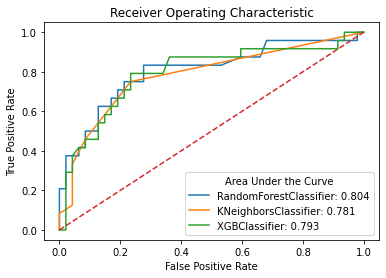

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import roc_curve, auc

for model_name in top_models:
    y_proba = probas[model_name]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{model_name}: {auc(fpr, tpr):>.3f}')

plt.plot([0,1], [0,1], linestyle='--')
plt.legend(title='Area Under the Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.savefig('new_roc_curve.png')
plt.show()

<a id='class'></a>
## Class distribution

In [11]:
def percentage_dist(values):
    values = pd.Series(values, name='values')
    distribution = values.value_counts(
        normalize=True).mul(100).reset_index().rename({'values':'Percentage','index':'Class'}, axis=1)
    return distribution

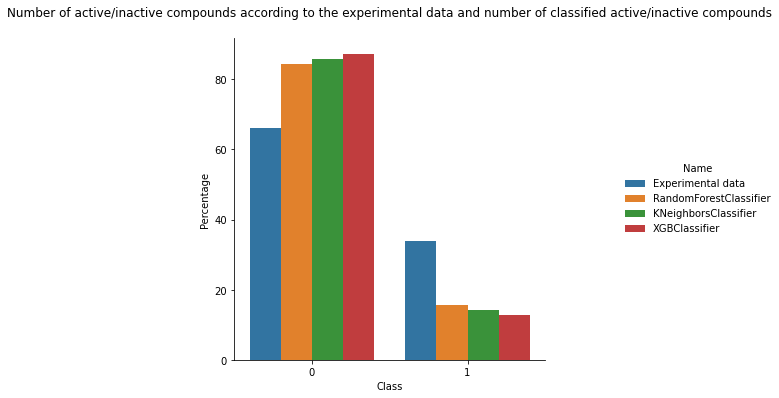

In [14]:
perc = percentage_dist(test_data[activity_label])
perc['Name'] = 'Experimental data'

for model_name in top_models:
    y_pred = Y[model_name]
    dist = percentage_dist(y_pred)
    dist['Name'] = model_name
    perc = perc.append(dist)

sns.catplot(kind='bar', data=perc, x='Class', y='Percentage', hue='Name')
plt.title('Number of active/inactive compounds according to the experimental data and number of classified active/inactive compounds', y=1.05)
plt.show()

<a id='spearman'></a>
## Spearman correlations

In [16]:
from scipy.stats import spearmanr

df = pd.merge(activity[['CID', 'f_inhibition_at_50_uM']], probas, on=['CID'])
print('Spearman R')
for model_name in top_models:
    print(f'{model_name}: {spearmanr(df[model_name], df["f_inhibition_at_50_uM"])[1]:.2f}')

Spearman R
RandomForestClassifier: 0.00
KNeighborsClassifier: 0.00
XGBClassifier: 0.00


<a id='error'></a>
## Error metrics

In [17]:
def error_metrics(y_test, y_proba):
    import numpy as np
    from sklearn.metrics import log_loss
    
    rmse = np.linalg.norm(y_proba - y_test) / np.sqrt(len(y_test))
    logl = log_loss(y_test, y_proba)
    return rmse, logl
    print('{:.4f}'.format())

In [18]:
print('{:20s}\t{:5s}\t{:5s}'.format('Model', 'RMSE', 'log_loss'))
for model_name in top_models:
    rmse, logl = error_metrics(y_test, probas[model_name])
    print(f'{model_name:20s}\t{rmse:.4f}\t{logl:.4f}')

Model               	RMSE 	log_loss
RandomForestClassifier	0.4139	0.5216
KNeighborsClassifier	0.4485	3.2370
XGBClassifier       	0.4666	0.8286
